#### DOMAIN: Social Media Analytics
#### CONTEXT: 
Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these require the availability of contextual tweets. In this project, the goal is to build a model to detect whether a sentence is sarcastic or not, using Bidirectional LSTMs.  

#### DATASET DESCRIPTION:
The dataset is collected from two news websites, theonion.com and huffingtonpost.com. This new dataset has the following advantages over the existing Twitter datasets:
Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and increases the chance of finding pre-trained embeddings. Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets. Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in teasing apart the real sarcastic elements, 

#### Content: 
Each record consists of three attributes:
- is_sarcastic: 1 if the record is sarcastic otherwise 0
- headline: the headline of the news article
- article_link: link to the original news article. Useful in collecting supplementary data

#### Reference: 
https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection

#### PROJECT OBJECTIVE: 
Build a sequential NLP classifier which can use input text parameters to determine the
customer 

5. Get indices for words [1 Marks]

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd                                                 # for panel data analysis
pd.set_option('display.max_columns', None)                          # Unfolding hidden features if the cardinality is high      
pd.set_option('display.max_colwidth', None)                         # Unfolding the max feature width for better clrity      
pd.set_option('display.max_rows', None)                             # Unfolding hidden data points if the cardinality is high
pd.set_option('display.float_format', lambda x: '%.3f' % x)         # To suppress scientific notation over exponential values
#-------------------------------------------------------------------------------------------------------------------------------
import numpy as np                                                  # Importing package numpys (For Numerical Python)
#-------------------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt                                     # Importing pyplot interface using matplotlib
from matplotlib.pylab import rcParams                               # Backend used for rendering and GUI integration                                               
import seaborn as sns                                               # Importin seaborn library for interactive visualization
#set seaborn plotting aesthetics
sns.set(style='whitegrid')
%matplotlib inline 

In [3]:
import nltk
import re
import re,string,unicodedata
from nltk.corpus import stopwords

In [4]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

## 1. Read and explore the data

In [5]:
df = pd.read_json("../input/sarcam-headlines-dataset-rishab-mishra/Sarcasm_Headlines_Dataset.json", lines=True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5,former versace store clerk sues over secret 'black code' for minority shoppers,0
1,https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
2,https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697,mom starting to fear son's web series closest thing she will have to grandchild,1
3,https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
4,https://www.huffingtonpost.com/entry/jk-rowling-wishes-snape-happy-birthday_us_569117c4e4b0cad15e64fdcb,j.k. rowling wishes snape happy birthday in the most magical way,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [7]:
df.shape

(26709, 3)

In [8]:
#checking for null values in train data
df.isnull().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [9]:
df.describe(include='object')

,article_link,headline
count,26709,26709
unique,26708,26602
top,https://www.huffingtonpost.comhttp://nymag.com/daily/intelligencer/2016/05/hillary-clinton-candidacy.html,sunday roundup
freq,2,10


In [10]:
#checking for duplicate values
df['headline'].duplicated().sum()

107

**Dropping Duplicates**

In [11]:
df=df.drop(df[df['headline'].duplicated()].index,axis=0)

having an idea of predictor feature

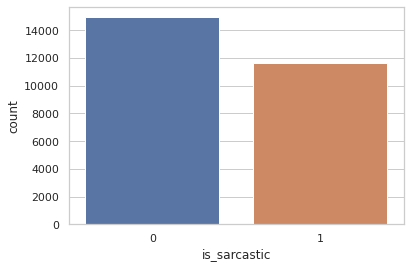

In [12]:
sns.countplot(df['is_sarcastic'])
plt.show()

data is fairly balanced

## 2. Retain relevant columns 

In [13]:
df.drop(columns = ['article_link'], inplace=True)

## 3. Length of each sentence

In [14]:
df['headline_length'] = df['headline'].apply(len)
df[['headline','headline_length']].head()

,headline,headline_length
0,former versace store clerk sues over secret 'black code' for minority shoppers,78
1,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",84
2,mom starting to fear son's web series closest thing she will have to grandchild,79
3,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",84
4,j.k. rowling wishes snape happy birthday in the most magical way,64


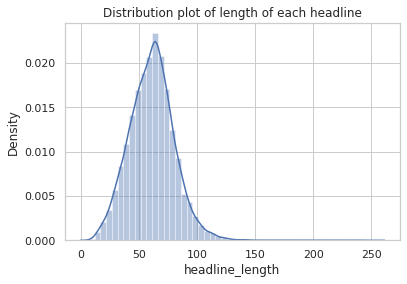

In [15]:
sns.distplot(df.headline_length, kde=True)
plt.title('Distribution plot of length of each headline')
plt.show()

comparison between lengths of headlines with sarcasm and those without

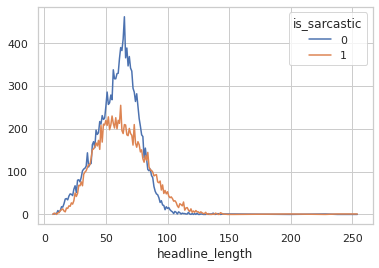

In [16]:
pd.crosstab(df['headline_length'],df['is_sarcastic']).plot()
plt.show()

sentences with sarcam tend to be shorter on average than sentences carrying tone of sarcasm in them

## 4. Define parameters

In [17]:
max_features = 10000
maxlen = 40
embedding_size = 50

## Preprocessing

### Stopword removal

In [18]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Removing the stopwords from text
def split_into_words(text):
    # split into words by white space
    words = text.split()
    return words

def to_lower_case(words):
    # convert to lower case
    words = [word.lower() for word in words]
    return words

def remove_punctuation(words):
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    stripped = [re_punc.sub('', w) for w in words]
    return stripped

def keep_alphabetic(words):
    # remove remaining tokens that are not alphabetic
    words = [word for word in words if word.isalpha()]
    return words

def remove_stopwords(words):
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    return words

def to_sentence(words):
    # join words to a sentence
    return ' '.join(words)

#Removing the noisy text
def denoise_text(text):
    words = split_into_words(text)
    words = to_lower_case(words)
    words = remove_punctuation(words)
    words = keep_alphabetic(words)
    words = remove_stopwords(words)
    return to_sentence(words)

In [19]:
df['headline']=df['headline'].apply(denoise_text)

## 6. Create features and labels

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(df['headline']))

X = tokenizer.texts_to_sequences(df['headline'])
print("Number of Samples:", len(X))       
print(X[0]) 

Number of Samples: 26602
[197, 671, 3642, 2085, 258, 32, 1988, 2349, 7978]


In [21]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = pad_sequences(X, maxlen = maxlen)     
y = np.asarray(df['is_sarcastic'])

print("Number of Labels: ", len(y))     
print(y[0])

Number of Labels:  26602
0


In [22]:
X.shape

(26602, 40)

## 7. Get vocabulary size

In [23]:
num_words = len(tokenizer.word_index) + 1
print('The vocabulary size is',num_words)

The vocabulary size is 27395


### 8. Create a weight matrix using GloVe embeddings

In [24]:
EMBEDDING_FILE = '../input/glove-global-vectors-for-word-representation/glove.6B.50d.txt'
embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    embeddings[word] = embd

In [25]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, 50))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [26]:
print (len(embeddings))

400000


In [27]:
print(embedding_matrix.shape)

(27395, 50)


In [28]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_encoded = enc.fit_transform(y.reshape(-1,1))
y_encoded

<26602x2 sparse matrix of type '<class 'numpy.float64'>'
	with 26602 stored elements in Compressed Sparse Row format>

Convert sparse scipy matrix to nd array

In [29]:
y_encoded = y_encoded.todense()
y_encoded

matrix([[1., 0.],
        [1., 0.],
        [0., 1.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]])

In [30]:
X
print(X.shape)

(26602, 40)


### Splitting the data into train and test

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state = 42, stratify=y_encoded, test_size=0.2)

In [32]:
print(X_train.shape, X_test.shape)

(21281, 40) (5321, 40)


### 9. Define and compile a Bidirectional LSTM model

In [33]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience = 2, verbose=1,factor=0.3, 
                                            min_lr=0.000001)

In [34]:
batch_size = 64

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Flatten, BatchNormalization
from functools import partial
from tensorflow.keras.layers import BatchNormalization

In [45]:
model1 = Sequential([
    Embedding(num_words, embedding_size, weights = [embedding_matrix], input_length=maxlen),
    Bidirectional(LSTM(128, return_sequences = True)),
    Flatten(),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation = 'relu'),
    Dense(2, activation="sigmoid")
])

In [41]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

In [42]:
METRICS = [
    'accuracy',
    Precision(name='precision'),
    Recall(name='recall')
]

In [46]:
model1.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=METRICS)
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 50)            1369750   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 40, 256)           183296    
_________________________________________________________________
flatten_2 (Flatten)          (None, 10240)             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10240)             40960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10240)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2621696   
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)              

In [47]:
MODEL1 = model1.fit(X_train, y_train, batch_size=batch_size, 
                    epochs=10, validation_data = (X_test, y_test), 
                    initial_epoch=0, callbacks = [learning_rate_reduction])

Epoch 1/10
333/333 [==============================] - 9s 18ms/step - loss: 0.5631 - accuracy: 0.7241 - precision: 0.8402 - recall: 0.8420 - val_loss: 0.5460 - val_accuracy: 0.7640 - val_precision: 0.7632 - val_recall: 0.7579
Epoch 2/10
333/333 [==============================] - 5s 14ms/step - loss: 0.4074 - accuracy: 0.8121 - precision: 0.8120 - recall: 0.8116 - val_loss: 0.4150 - val_accuracy: 0.8123 - val_precision: 0.8114 - val_recall: 0.8100
Epoch 3/10
333/333 [==============================] - 6s 17ms/step - loss: 0.2980 - accuracy: 0.8727 - precision: 0.8724 - recall: 0.8720 - val_loss: 0.3884 - val_accuracy: 0.8265 - val_precision: 0.8246 - val_recall: 0.8277
Epoch 4/10
333/333 [==============================] - 5s 14ms/step - loss: 0.2240 - accuracy: 0.9092 - precision: 0.9087 - recall: 0.9092 - val_loss: 0.4477 - val_accuracy: 0.8222 - val_precision: 0.8249 - val_recall: 0.8196
Epoch 5/10
333/333 [==============================] - 5s 15ms/step - loss: 0.1713 - accuracy: 0.9317

In [48]:
def evolution(model, epochs):
    epochs = range(1,epochs+1)
    
    plt.figure(figsize=(10, 15))
    
    plt.subplot(4, 2, 1)
    loss_train = model.history['loss']
    loss_val = model.history['val_loss']
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='validation loss')
    plt.title('Loss Function Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    
    plt.subplot(4, 2, 2)
    accuracy_train = model.history['accuracy']
    accuracy_val = model.history['val_accuracy']
    plt.plot(epochs, accuracy_train, 'g', label='Training accuracy')
    plt.plot(epochs, accuracy_val, 'b', label='validation accuracy')
    plt.title('Accuracy Function Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(4, 2, 3)
    precision_train = model.history['precision']
    precision_val = model.history['val_precision']
    plt.plot(epochs, precision_train, 'g', label='Training precision')
    plt.plot(epochs, precision_val, 'b', label='validation precision')
    plt.title('Precision Function Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()



    plt.subplot(4, 2, 4)
    recall_train = model.history['recall']
    recall_val = model.history['val_recall']
    plt.plot(epochs, recall_train, 'g', label='Training recall')
    plt.plot(epochs, recall_val, 'b', label='validation recall')
    plt.title('Recall Function Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
  

    return()

### 10. Fit the model and check the validation accuracy

In [58]:
predictions = model1.predict(X_test.reshape(len(X_test), 40))
y_pred = np.argmax(predictions, axis=-1)
y_test_inv = enc.inverse_transform(y_test)

In [59]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [61]:
print('Accuracy score is:', accuracy_score(y_test_inv, y_pred))
print('Confusion Matrix is:\n', confusion_matrix(y_test_inv, y_pred))
print('-'*20)
print('Classification Report is as follows:\n', classification_report(y_test_inv, y_pred))

Accuracy score is: 0.8161999624130802
Confusion Matrix is:
 [[2504  487]
 [ 491 1839]]
--------------------
Classification Report is as follows:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      2991
           1       0.79      0.79      0.79      2330

    accuracy                           0.82      5321
   macro avg       0.81      0.81      0.81      5321
weighted avg       0.82      0.82      0.82      5321



()

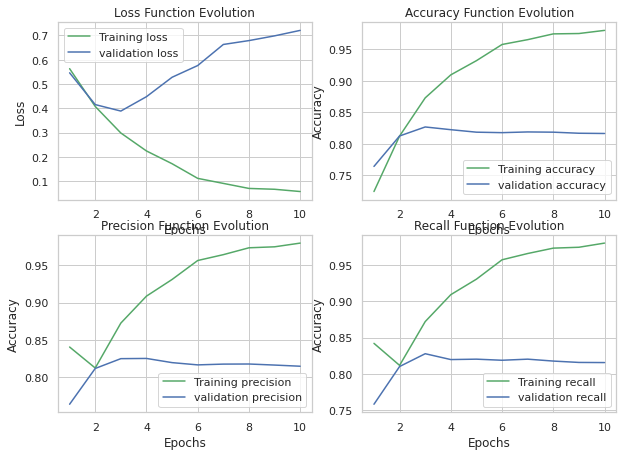

In [63]:
evolution(MODEL1, 10)

### Comments

After successive iterations, it is clear to me that I cannot device a model that does not overfit. Even the precision and recall scores are not encouraging. But considering the fact that it is my first attempt at creating a full fledged sentiment analysis system, I have done a good job of creating a network and trying to understand how things are. After applying a few more methods in my arsenal like early stopping etc, we can develop a better model.